# demo of graph optimisation to segment structures

In [2]:
from grace.datasets import random_graph
# from grace.models.datasets import dataset_from_graph
from grace.models.optimise import optimise_graph

import matplotlib.pyplot as plt
import numpy as np
from scipy.special import softmax

# import torch

In [3]:
G = random_graph(n_lines=25, density=0.05)

In [4]:
# model = torch.load("./gcn.pt")

In [5]:
def get_node_predictions(G, model):
    model.eval()

    predictions = []
    dataset = dataset_from_graph(G)

    for data in dataset:  # Iterate in batches over the training/test dataset.
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        probs = softmax(out.detach().numpy())

        predictions.append((int(pred.numpy()), probs))

    # this is the prediction that the node is in the object
    for (_, node), pred in zip(G.nodes.data(), predictions):
        # for a FP, we want this to be the prob that it's *NOT* in the object
        # print(pred)
        node["prob_detection"] = np.clip(float(pred[1][0, 0]), 0, 1)

    return G

In [2]:
def get_edge_predictions(G, model):
    # TODO
    pass

In [6]:
# NOTE(arl): this is *super* hacky - just to see if the optimisation works

def update_graph_dummy(G):

    # G = get_predictions(G, model)

    nodes = list(G.nodes.data())

    for _, node in nodes:
        pd = np.random.random()*0.5
        if node["label"] > 0:
            node["prob_detection"] = pd
        else:
            node["prob_detection"] = 1-pd

    
    for edge in G.edges.data():
        pd = np.random.random()*0.1
        _, e_i = nodes[edge[0]]
        _, e_j = nodes[edge[1]]
        
        if e_i["object_idx"] == e_j["object_idx"] and e_i["label"] > 0:
            edge[2]["prob_link"] = 1 - pd
        else:
            edge[2]["prob_link"] = pd 


In [7]:
update_graph_dummy(G)

In [8]:
x = optimise_graph(G)

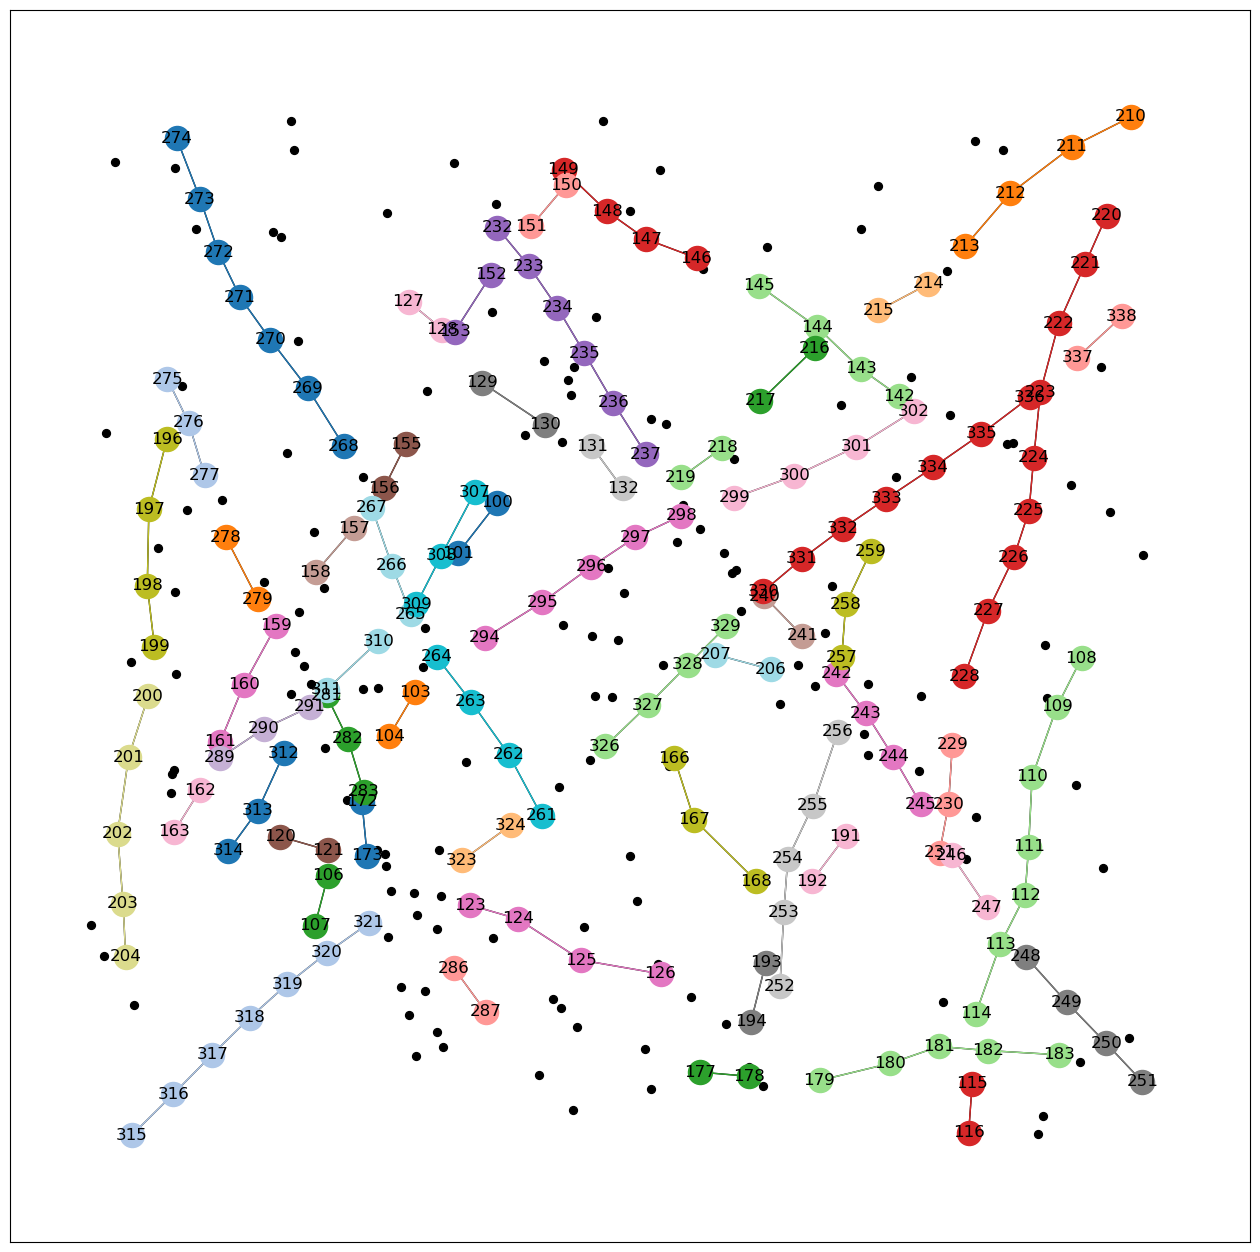

In [9]:
import networkx as nx

# plt.ion()

pos = {idx: (node["x"], node["y"]) for idx, node in x.nodes(data=True)}
fig, ax = plt.subplots(figsize=(16, 16))

# draw all nodes/vertices in the graph, including those not determined to be 
# part of the objects
nx.draw_networkx(x, ax=ax, pos=pos, with_labels=False, node_color="k", node_size=32)

# get each connected subgraph and draw it with a different colour
cc = nx.connected_components(x)
for index, sg in enumerate(cc):
    if len(sg) <= 1:
        continue

    c_idx = np.array(plt.cm.tab20((index % 20) / 20)).reshape(1, -1)
    sg = x.subgraph(sg).copy()
    nx.draw_networkx(sg, pos=pos, edge_color=c_idx, node_color=c_idx)
plt.show()